In [1]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取数据
light_data = pd.read_csv('/Users/hansen/Desktop/MATH3836proj/香港物种数据/2022年光强.csv')
species_data = pd.read_csv('/Users/hansen/Desktop/MATH3836proj/香港物种数据/2022年物种_最终版.csv')

# 检查并清理数据
# 确保经纬度列为数值型
light_data['latitude'] = pd.to_numeric(light_data['latitude'])
light_data['longitude'] = pd.to_numeric(light_data['longitude'])
species_data['latitude'] = pd.to_numeric(species_data['latitude'])
species_data['longitude'] = pd.to_numeric(species_data['longitude'])

# 确保nsb列(夜空亮度)为数值型
light_data['nsb'] = pd.to_numeric(light_data['nsb'])


In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    计算两个经纬度点之间的距离（单位：公里）
    """
    # 将经纬度转换为弧度
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # 经纬度差值
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine公式
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # 地球平均半径，单位为公里
    
    return c * r

# 为每个物种观测点找到所有2公里范围内的光照观测站
def find_nearby_light_stations(species_row, light_data):
    """
    找到距离物种观测点2公里以内的所有光照观测站
    """
    nearby_stations = []
    
    for _, light_row in light_data.iterrows():
        # 如果光照观测月份与物种观测月份相同
        if light_row['month'] == species_row['month']:
            dist = haversine_distance(
                species_row['latitude'], species_row['longitude'],
                light_row['latitude'], light_row['longitude']
            )
            
            if dist < 2:  # 如果距离小于2公里
                nearby_stations.append({
                    'location_id': light_row['location_id'],  # 使用location_id代替station
                    'distance': dist,
                    'nsb': light_row['nsb']
                })
    
    return nearby_stations

# 为每个物种观测点分配光照强度
species_with_light = []

for _, species_row in species_data.iterrows():
    nearby_stations = find_nearby_light_stations(species_row, light_data)
    
    if nearby_stations:  # 如果有附近的光照观测站
        # 计算平均光照强度
        avg_nsb = sum(station['nsb'] for station in nearby_stations) / len(nearby_stations)
        
        species_with_light.append({
            'scientific': species_row['scientific'],
            'month': species_row['month'],
            'gno': species_row['gno'],
            'count': species_row['count'],
            'latitude': species_row['latitude'],
            'longitude': species_row['longitude'],
            'nsb': avg_nsb,
            'stations_count': len(nearby_stations),
            'stations': [s['location_id'] for s in nearby_stations]  # 存储location_id列表
        })
    else:
        # 没有附近的光照观测站，标记为缺失值
        species_with_light.append({
            'scientific': species_row['scientific'],
            'month': species_row['month'],
            'gno': species_row['gno'],
            'count': species_row['count'],
            'latitude': species_row['latitude'],
            'longitude': species_row['longitude'],
            'nsb': None,
            'stations_count': 0,
            'stations': []
        })

# 转换为DataFrame
result_df = pd.DataFrame(species_with_light)

# 显示DataFrame的前几行
print("\nDataFrame前5行:")
print(result_df.head())



DataFrame前5行:
         scientific  month   gno  count   latitude   longitude  nsb  \
0  Abisara echerius      4  1482      2  22.400077  113.921772  NaN   
1  Abisara echerius      4  2609      1  22.255681  113.989945  NaN   
2  Abisara echerius      4  1575      1  22.391244  114.145139  NaN   
3  Abisara echerius      4   878      1  22.481552  114.174270  NaN   
4  Abisara echerius      4   948      2  22.472521  114.174270  NaN   

   stations_count stations  
0               0       []  
1               0       []  
2               0       []  
3               0       []  
4               0       []  


In [4]:
# 创建一个字典，将每个唯一的scientific名称映射到一个唯一的编号
species_to_id = {}
current_id = 1

# 为每个唯一的物种分配一个ID
for scientific in result_df['scientific'].unique():
    species_to_id[scientific] = current_id
    current_id += 1

# 使用映射添加物种ID列
result_df['species_id'] = result_df['scientific'].map(species_to_id)

# 显示DataFrame的前几行
print("\nDataFrame前5行(包含物种ID):")
print(result_df.head())



DataFrame前5行(包含物种ID):
         scientific  month   gno  count   latitude   longitude  nsb  \
0  Abisara echerius      4  1482      2  22.400077  113.921772  NaN   
1  Abisara echerius      4  2609      1  22.255681  113.989945  NaN   
2  Abisara echerius      4  1575      1  22.391244  114.145139  NaN   
3  Abisara echerius      4   878      1  22.481552  114.174270  NaN   
4  Abisara echerius      4   948      2  22.472521  114.174270  NaN   

   stations_count stations  species_id  
0               0       []           1  
1               0       []           1  
2               0       []           1  
3               0       []           1  
4               0       []           1  


In [5]:
# 删除指定的列
columns_to_drop = ['count', 'stations_count', 'latitude', 'longitude']
result_df = result_df.drop(columns=columns_to_drop)

# 显示DataFrame的前几行
print("\nDataFrame前5行(删除指定列后):")
print(result_df.head())

# 显示剩余的列名
print("\n剩余的列名:")
print(result_df.columns.tolist())



DataFrame前5行(删除指定列后):
         scientific  month   gno  nsb stations  species_id
0  Abisara echerius      4  1482  NaN       []           1
1  Abisara echerius      4  2609  NaN       []           1
2  Abisara echerius      4  1575  NaN       []           1
3  Abisara echerius      4   878  NaN       []           1
4  Abisara echerius      4   948  NaN       []           1

剩余的列名:
['scientific', 'month', 'gno', 'nsb', 'stations', 'species_id']


In [6]:
# 定义各类别的物种ID列表
birds = [8, 9, 10, 11, 12, 16, 17, 18, 19, 20, 21, 29, 30, 31, 37, 38, 39, 40, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 56, 70, 71, 72, 84, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 104, 113, 114, 117, 119, 123, 124, 125, 130, 131, 132, 134, 135, 139, 143, 145, 147, 148, 153, 154, 157, 158, 159, 162, 171, 176, 177, 179, 180, 181, 187, 188, 189, 190, 194, 195, 196, 197, 201, 202, 210, 222, 223, 224, 225, 226, 228, 229, 230, 231, 233, 236, 237, 242, 243, 251, 252, 260, 261, 262, 271, 276, 277, 283, 284, 287, 294, 308, 309, 318, 325, 326, 327, 328, 329, 330, 337, 343, 344, 345, 346, 349, 362, 363, 378, 385, 386, 387, 388, 392, 393, 394, 395, 398, 420, 427, 428, 446, 447, 449, 450, 474, 475, 479, 480, 484, 485, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 510, 511, 512, 524, 525, 543, 544, 545, 546, 547, 548, 551, 552, 553, 563, 564, 565, 578, 580, 588, 595, 596, 597, 600, 601, 604, 605, 606, 609, 610, 611, 612, 613, 614, 617, 622, 632, 633, 636, 637, 645, 649, 650, 651, 652, 653, 654, 655, 660, 661, 662, 663, 664, 668, 669, 671, 672, 678, 690, 691]

mammals = [79, 83, 100, 149, 161, 272, 273, 278, 279, 296, 352, 370, 378, 379, 380, 381, 391, 399, 400, 401, 449, 526, 562, 570, 571, 572, 579, 618, 619, 665, 666, 677]

reptiles = [65, 85, 101, 160, 215, 227, 234, 265, 266, 267, 268, 295, 302, 303, 353, 354, 425, 431, 432, 508, 509, 533, 549, 550, 558, 566, 583, 584, 589, 593, 629, 647, 648, 659]

amphibians = [33, 186, 221, 280, 281, 289, 319, 320, 331, 340, 375, 376, 377, 424, 465, 507, 559, 620]

fish = [5, 6, 7, 13, 28, 32, 48, 75, 76, 77, 105, 120, 121, 122, 136, 140, 141, 151, 163, 191, 218, 219, 220, 239, 241, 263, 264, 269, 275, 292, 293, 341, 350, 351, 389, 390, 434, 435, 445, 471, 481, 513, 534, 539, 540, 568, 569, 581, 582, 591, 627, 628, 635, 646, 676, 679, 680]

butterflies_moths = [1, 2, 15, 22, 23, 34, 35, 56, 57, 58, 59, 60, 61, 62, 73, 74, 78, 86, 87, 102, 103, 106, 107, 108, 109, 111, 112, 115, 126, 127, 128, 129, 133, 154, 155, 156, 165, 166, 169, 170, 172, 173, 182, 183, 184, 193, 200, 207, 208, 209, 211, 212, 213, 254, 255, 256, 259, 274, 282, 285, 290, 291, 297, 299, 310, 311, 312, 313, 314, 315, 316, 317, 321, 323, 324, 333, 334, 335, 336, 338, 339, 357, 360, 361, 367, 368, 369, 384, 396, 397, 402, 403, 407, 408, 409, 410, 411, 417, 423, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 472, 473, 476, 483, 484, 502, 503, 505, 515, 516, 517, 521, 522, 523, 527, 528, 531, 561, 573, 577, 594, 602, 603, 615, 621, 623, 624, 625, 626, 630, 631, 640, 641, 642, 658, 667, 673, 674, 681, 682, 683, 684, 685, 686, 687, 688, 689]

dragonflies_damselflies = [14, 26, 27, 36, 41, 42, 43, 63, 80, 82, 88, 94, 116, 142, 144, 150, 182, 185, 198, 203, 249, 250, 257, 258, 301, 305, 332, 355, 356, 359, 360, 365, 383, 404, 405, 412, 413, 414, 439, 440, 441, 442, 443, 451, 462, 463, 464, 529, 530, 532, 535, 536, 537, 538, 541, 573, 574, 575, 576, 590, 592, 638, 639, 643, 644, 656, 657, 670, 692, 693, 694]

fireflies_beetles = [51, 174, 175, 347, 348, 544, 545, 554, 555, 556, 557, 567, 607, 675]

other_invertebrates = [235, 270, 421, 422, 468, 469, 470, 585, 586]

# 定义函数来确定物种类别
def get_species_category(species_id):
    if species_id in birds:
        return 1
    elif species_id in mammals:
        return 2
    elif species_id in reptiles:
        return 3
    elif species_id in amphibians:
        return 4
    elif species_id in fish:
        return 5
    elif species_id in butterflies_moths:
        return 6
    elif species_id in dragonflies_damselflies:
        return 7
    elif species_id in fireflies_beetles:
        return 8
    
    else:
        return 9  

# 添加新列到DataFrame
result_df['category'] = result_df['species_id'].apply(get_species_category)

# 可选：添加类别名称列
category_names = {
    1: '鸟类',
    2: '哺乳动物',
    3: '爬行动物',
    4: '两栖动物',
    5: '鱼类',
    6: '昆虫(蝴蝶和蛾类)',
    7: '昆虫(蜻蜓和豆娘)',
    8: '昆虫(萤火虫和甲虫)',
    9: '其他无脊椎动物',
    
}

result_df['category_name'] = result_df['category'].map(category_names)

# 显示结果的前几行
print(result_df.head())


         scientific  month   gno  nsb stations  species_id  category  \
0  Abisara echerius      4  1482  NaN       []           1         6   
1  Abisara echerius      4  2609  NaN       []           1         6   
2  Abisara echerius      4  1575  NaN       []           1         6   
3  Abisara echerius      4   878  NaN       []           1         6   
4  Abisara echerius      4   948  NaN       []           1         6   

  category_name  
0     昆虫(蝴蝶和蛾类)  
1     昆虫(蝴蝶和蛾类)  
2     昆虫(蝴蝶和蛾类)  
3     昆虫(蝴蝶和蛾类)  
4     昆虫(蝴蝶和蛾类)  


In [7]:
import pandas as pd

# 假设 result_df 是你的 DataFrame
filtered_df = result_df[result_df['nsb'].notna()]

# 显示过滤后的 DataFrame
print(filtered_df)


                  scientific  month  gno        nsb stations  species_id  \
37          Abisara echerius     11  860  13.762746     [10]           1   
56         Accipiter gularis     11  931  13.762746     [10]           8   
57           Accipiter nisus     10  931  13.221697     [10]           9   
63     Accipiter trivirgatus     10  930  13.221697     [10]          11   
67        Accipiter virgatus      7  930  11.563271     [10]          12   
...                      ...    ...  ...        ...      ...         ...   
11141      Zosterops simplex     12  930  14.166822     [10]         691   
11142      Zosterops simplex     12  931  14.166822     [10]         691   
11173     Zyxomma petiolatum      4  930  11.943803     [10]         694   
11174     Zyxomma petiolatum      5  930  11.488828     [10]         694   
11175     Zyxomma petiolatum      6  860  11.636687     [10]         694   

       category category_name  
37            6     昆虫(蝴蝶和蛾类)  
56            1        

In [8]:
# 重置索引
filtered_df = filtered_df.reset_index(drop=True)

# 显示重置索引后的 DataFrame
print(filtered_df)
valid_data=filtered_df

                 scientific  month  gno        nsb stations  species_id  \
0          Abisara echerius     11  860  13.762746     [10]           1   
1         Accipiter gularis     11  931  13.762746     [10]           8   
2           Accipiter nisus     10  931  13.221697     [10]           9   
3     Accipiter trivirgatus     10  930  13.221697     [10]          11   
4        Accipiter virgatus      7  930  11.563271     [10]          12   
...                     ...    ...  ...        ...      ...         ...   
2969      Zosterops simplex     12  930  14.166822     [10]         691   
2970      Zosterops simplex     12  931  14.166822     [10]         691   
2971     Zyxomma petiolatum      4  930  11.943803     [10]         694   
2972     Zyxomma petiolatum      5  930  11.488828     [10]         694   
2973     Zyxomma petiolatum      6  860  11.636687     [10]         694   

      category category_name  
0            6     昆虫(蝴蝶和蛾类)  
1            1            鸟类  
2     

In [9]:
import pandas as pd

# 假设 valid_data 是你的 DataFrame

# 创建类别名称映射
category_names = {
    1: '鸟类',
    2: '哺乳动物',
    3: '爬行动物',
    4: '两栖动物',
    5: '鱼类',
    6: '昆虫(蝴蝶和蛾类)',
    7: '昆虫(蜻蜓和豆娘)',
    8: '昆虫(萤火虫和甲虫)',
    9: '其他无脊椎动物'
}

# 计算每个类别在匹配到光照强度的观测点中的数量
matched_counts = valid_data['category'].value_counts()

# 输出每个类别的名称和匹配到的数量
print("匹配到光照强度的观测点数量：")
for category in range(1, 10):
    count = matched_counts.get(category, 0)
    category_name = category_names.get(category, '未知类别')
    print(f'{category_name}: {count} 个样本')


匹配到光照强度的观测点数量：
鸟类: 1358 个样本
哺乳动物: 218 个样本
爬行动物: 55 个样本
两栖动物: 107 个样本
鱼类: 26 个样本
昆虫(蝴蝶和蛾类): 607 个样本
昆虫(蜻蜓和豆娘): 299 个样本
昆虫(萤火虫和甲虫): 26 个样本
其他无脊椎动物: 278 个样本


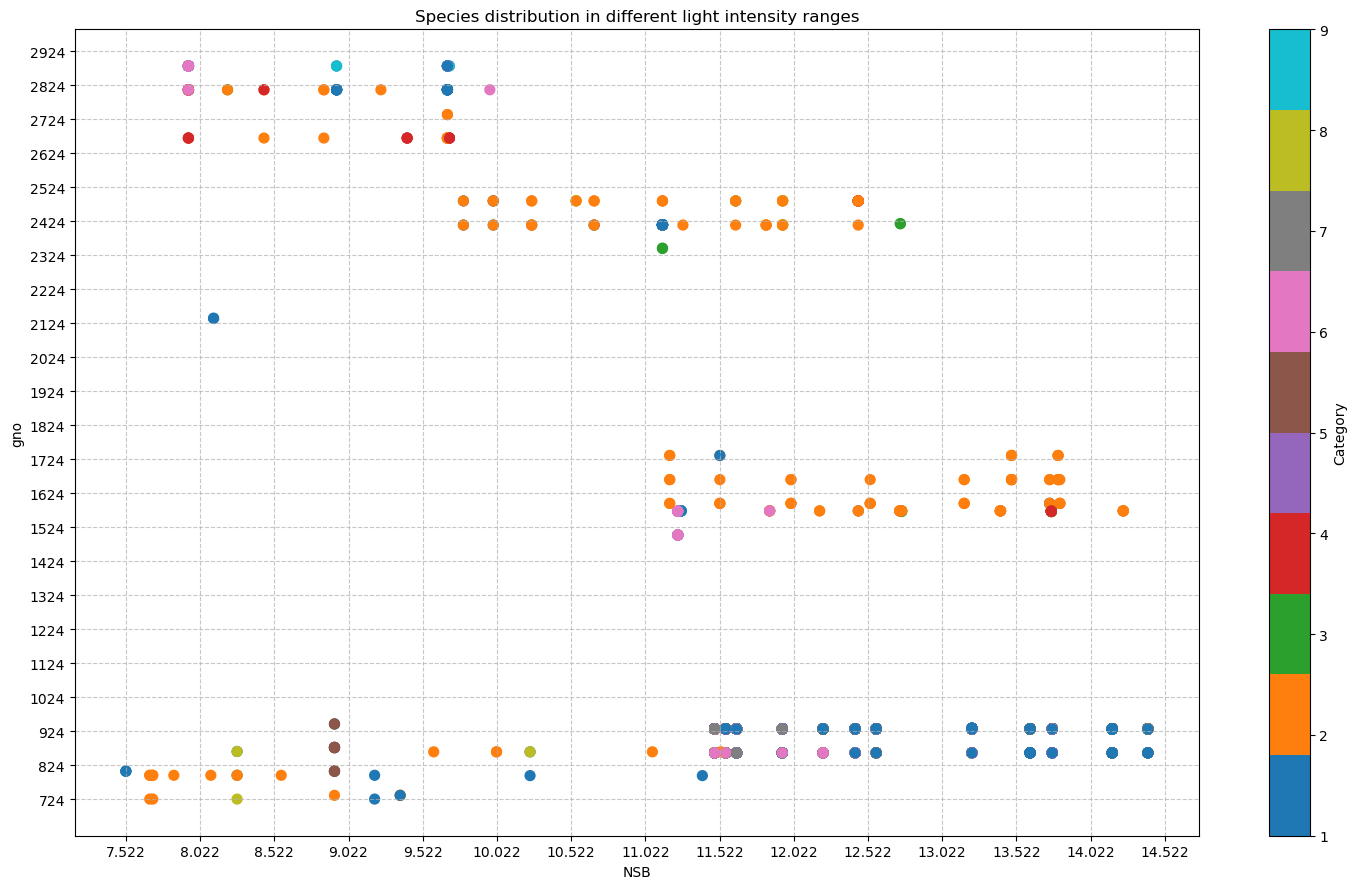

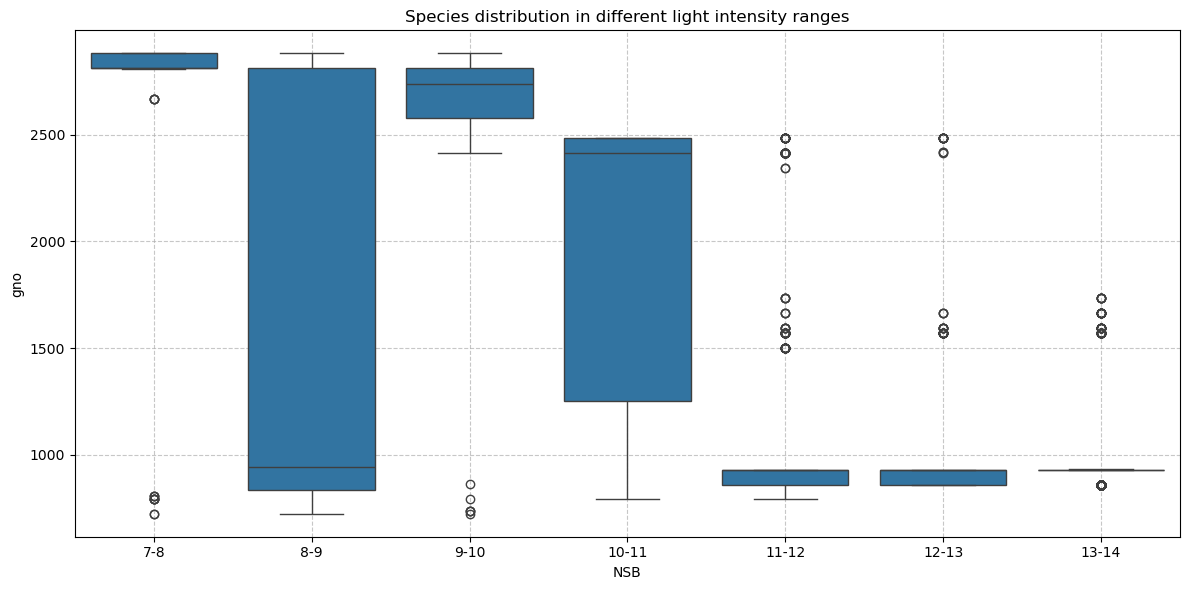

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假设 valid_data 是你的 DataFrame
# 删除 nsb 为空的行
valid_data = valid_data.dropna(subset=['nsb'])

# 创建散点图
plt.figure(figsize=(15, 9))  # 增大图像尺寸
scatter = plt.scatter(valid_data['nsb'], valid_data['gno'], 
                      c=valid_data['category'], cmap='tab10', alpha=1, s=50)
plt.title('Species distribution in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('gno')

# 设置坐标轴刻度
plt.xticks(ticks=np.arange(valid_data['nsb'].min(), valid_data['nsb'].max() + 0.5, 0.5))
plt.yticks(ticks=np.arange(valid_data['gno'].min(), valid_data['gno'].max() + 100, 100))

plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Category')
plt.tight_layout()
# plt.savefig('/Users/hansen/Desktop/光照强度与物种数量散点图.png')
plt.show()

# 创建箱线图，按照光照强度范围分组
# 将光照强度分为几个区间
valid_data['nsb_category'] = pd.cut(valid_data['nsb'], 
                                   bins=[7, 8, 9, 10, 11, 12, 13, 14],
                                   labels=['7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='nsb_category', y='gno', data=valid_data)
plt.title('Species distribution in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('gno')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('/Users/hansen/Desktop/不同光照强度区间的物种数量箱线图.png')
plt.show()


对每一个物种进行简单回归

线性回归模型统计数据：
截距（Intercept）：3615.669189537907
系数（Coefficients）：
  nsb: -203.80931202997678
  category_1: -6.04518365817235
  category_2: 390.05437815865366
  category_3: 68.1077279208228
  category_4: 124.49787287743044
  category_5: -467.49660156570064
  category_6: -67.7319702265754
  category_7: -236.95119867080362
  category_8: 269.60147297839234
  category_9: -74.03649781405034
R² 值：0.41


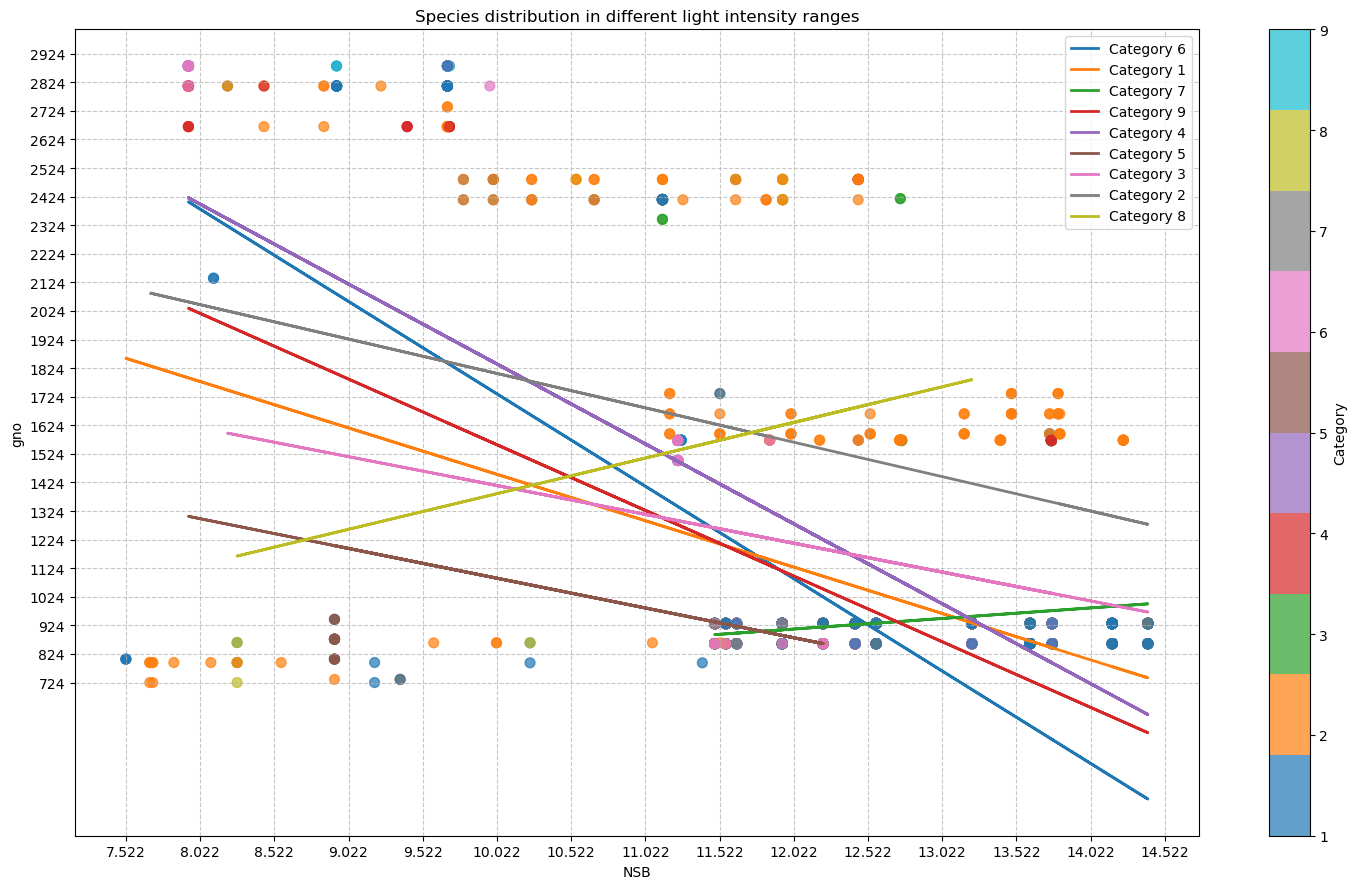

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 假设 valid_data 是你的 DataFrame

# 创建哑变量
dummy_variables = pd.get_dummies(valid_data['category'], prefix='category')

# 将哑变量添加到 DataFrame
valid_data_with_dummies = pd.concat([valid_data, dummy_variables], axis=1)

plt.figure(figsize=(15, 9))

# 绘制散点图
scatter = plt.scatter(valid_data['nsb'], valid_data['gno'], 
                      c=valid_data['category'], cmap='tab10', alpha=0.7, s=50)

# 准备数据
X = valid_data_with_dummies[['nsb'] + list(dummy_variables.columns)]
y = valid_data_with_dummies['gno']

# 多元线性回归模型
model = LinearRegression()
model.fit(X, y)

# 预测值
y_pred = model.predict(X)

# 模型评估
r2 = r2_score(y, y_pred)

# 输出统计数据
print("线性回归模型统计数据：")
print(f"截距（Intercept）：{model.intercept_}")
print("系数（Coefficients）：")
for feature, coef in zip(['nsb'] + list(dummy_variables.columns), model.coef_):
    print(f"  {feature}: {coef}")
print(f"R² 值：{r2:.2f}")

# 为每个类别绘制单独的回归线
categories = valid_data['category'].unique()
for category in categories:
    subset = valid_data[valid_data['category'] == category]
    X_subset = subset[['nsb']]
    y_subset = subset['gno']
    
    # 简单线性回归
    model_subset = LinearRegression()
    model_subset.fit(X_subset, y_subset)
    y_subset_pred = model_subset.predict(X_subset)
    
    plt.plot(subset['nsb'], y_subset_pred, linewidth=2, label=f'Category {category}')

plt.title('Species distribution in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('gno')
plt.xticks(ticks=np.arange(valid_data['nsb'].min(), valid_data['nsb'].max() + 0.5, 0.5))
plt.yticks(ticks=np.arange(valid_data['gno'].min(), valid_data['gno'].max() + 100, 100))
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Category')
plt.legend()
plt.tight_layout()
plt.show()


初步引入哑变量

线性回归模型统计数据：
截距（Intercept）：2747.1812937850355
系数（Coefficients）：
  nsb: -115.8842521174448
  category_1: 332.20792925347723
  category_2: 264.4554746830506
  category_3: -322.2567734095587
  category_4: 1893.7601395871075
  category_5: -614.4742704069896
  category_6: 2226.6840365676394
  category_7: -2279.953033698604
  category_8: -2611.90413232273
  category_9: 1111.4806297465948
  nsb_category_1: -46.44728303578048
  nsb_category_2: -4.47415648440546
  nsb_category_3: 14.941625086541356
  nsb_category_4: -163.74646320651462
  nsb_category_5: 11.742395016787526
  nsb_category_6: -207.39533555950982
  nsb_category_7: 152.81800328102284
  nsb_category_8: 240.55433932623606
  nsb_category_9: -113.87737654278692
R² 值：0.46


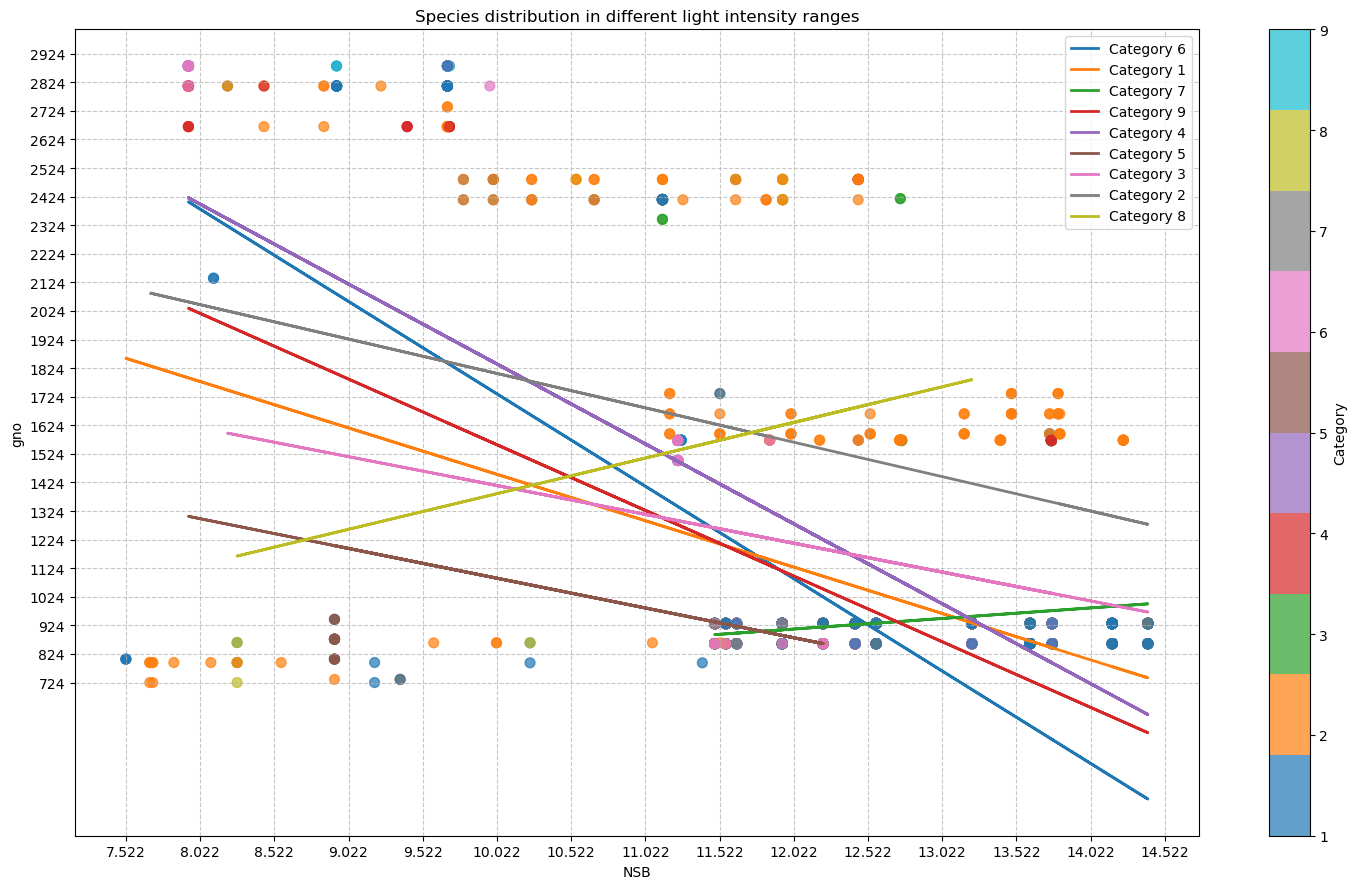

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 假设 valid_data 是你的 DataFrame

# 创建哑变量
dummy_variables = pd.get_dummies(valid_data['category'], prefix='category')

# 将哑变量添加到 DataFrame
valid_data_with_dummies = pd.concat([valid_data, dummy_variables], axis=1)

# 创建交互项
for category in dummy_variables.columns:
    valid_data_with_dummies[f'nsb_{category}'] = valid_data_with_dummies['nsb'] * valid_data_with_dummies[category]

# 准备数据
features = ['nsb'] + list(dummy_variables.columns) + [f'nsb_{category}' for category in dummy_variables.columns]
X = valid_data_with_dummies[features]
y = valid_data_with_dummies['gno']

# 多元线性回归模型
model = LinearRegression()
model.fit(X, y)

# 预测值
y_pred = model.predict(X)

# 模型评估
r2 = r2_score(y, y_pred)

# 输出统计数据
print("线性回归模型统计数据：")
print(f"截距（Intercept）：{model.intercept_}")
print("系数（Coefficients）：")
for feature, coef in zip(features, model.coef_):
    print(f"  {feature}: {coef}")
print(f"R² 值：{r2:.2f}")

# 绘制图形
plt.figure(figsize=(15, 9))
scatter = plt.scatter(valid_data['nsb'], valid_data['gno'], 
                      c=valid_data['category'], cmap='tab10', alpha=0.7, s=50)

# 为每个类别绘制单独的回归线
categories = valid_data['category'].unique()
for category in categories:
    subset = valid_data[valid_data['category'] == category]
    X_subset = subset[['nsb']]
    y_subset = subset['gno']
    
    # 简单线性回归
    model_subset = LinearRegression()
    model_subset.fit(X_subset, y_subset)
    y_subset_pred = model_subset.predict(X_subset)
    
    plt.plot(subset['nsb'], y_subset_pred, linewidth=2, label=f'Category {category}')

plt.title('Species distribution in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('gno')
plt.xticks(ticks=np.arange(valid_data['nsb'].min(), valid_data['nsb'].max() + 0.5, 0.5))
plt.yticks(ticks=np.arange(valid_data['gno'].min(), valid_data['gno'].max() + 100, 100))
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Category')
plt.legend()
plt.tight_layout()
plt.show()


添加nsb为2次的交互项

Ridge 回归模型统计数据：
截距（Intercept）：11148.23098771696
系数（Coefficients）：
  nsb: -1470.9330572071087
  category_1: 412.3237728693653
  category_2: -1703.787782933295
  category_3: 92.54582805890726
  category_4: 281.3743381240761
  category_5: 0.49806853822666397
  category_6: 966.624877465701
  category_7: -55.20048012505267
  category_8: -298.85577440377267
  category_9: 304.4771524253859
  nsb_category_1: -94.76728585865656
  nsb_category_2: 211.54017121201878
  nsb_category_3: -146.8965496361411
  nsb_category_4: -79.63721245110521
  nsb_category_5: -433.4176564194653
  nsb_category_6: -201.94059959788282
  nsb_category_7: -202.66480142437163
  nsb_category_8: -414.14379847860107
  nsb_category_9: -109.0053246153525
  nsb2_category_1: 57.35937527226403
  nsb2_category_2: 49.266539935749805
  nsb2_category_3: 64.5651730126197
  nsb2_category_4: 57.80811106778249
  nsb2_category_5: 87.79540731089836
  nsb2_category_6: 61.9811510199341
  nsb2_category_7: 68.62315401173954
  nsb2_category_8: 9

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e+08, tolerance: 7.217e+04
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e+08, tolerance: 7.217e+04
  model = cd_fast.enet_coordinate_descent(


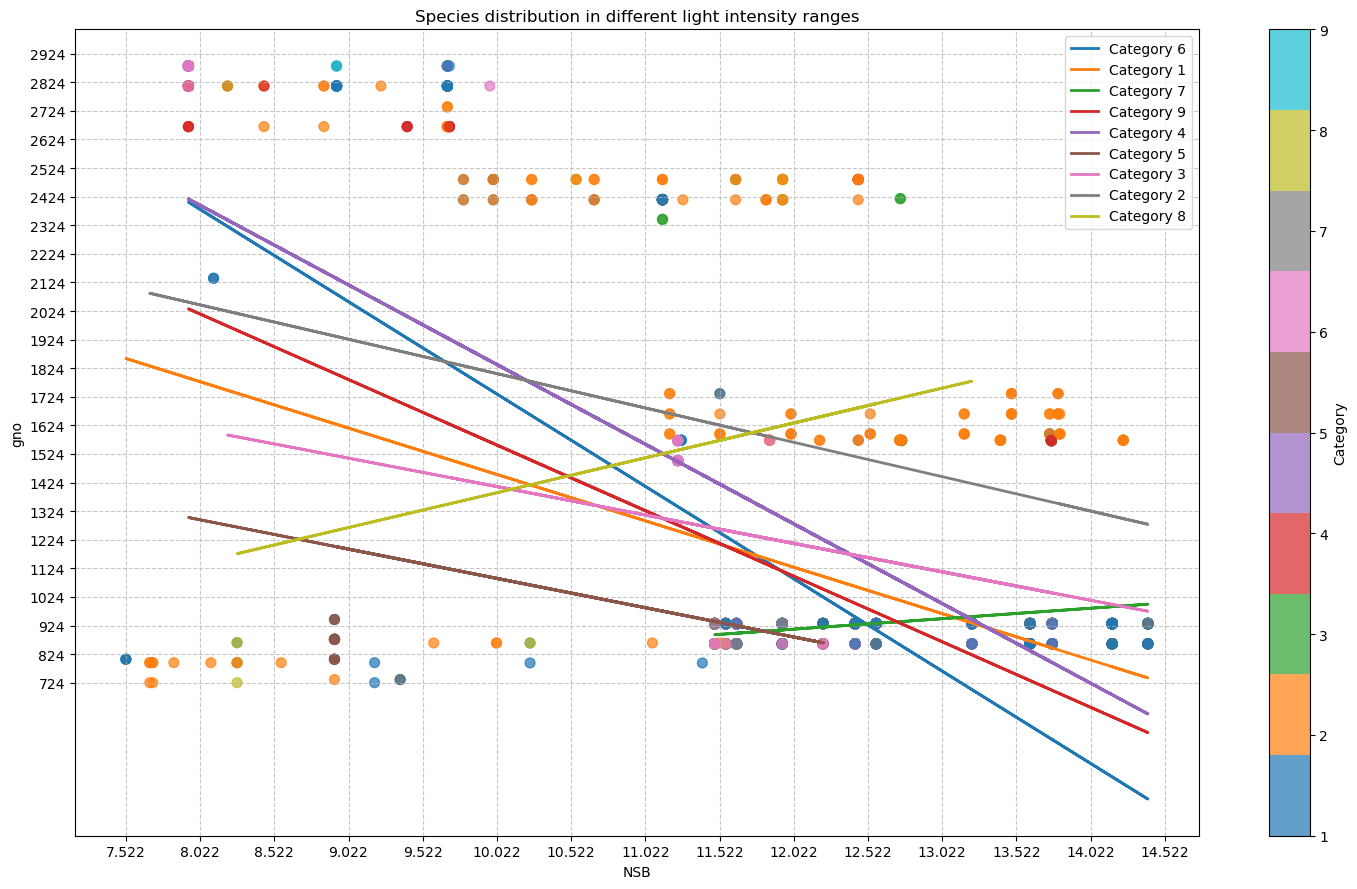

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score

# 假设 valid_data 是你的 DataFrame

# 创建哑变量
dummy_variables = pd.get_dummies(valid_data['category'], prefix='category')

# 将哑变量添加到 DataFrame
valid_data_with_dummies = pd.concat([valid_data, dummy_variables], axis=1)

# 创建交互项
for category in dummy_variables.columns:
    valid_data_with_dummies[f'nsb_{category}'] = valid_data_with_dummies['nsb'] * valid_data_with_dummies[category]
    valid_data_with_dummies[f'nsb2_{category}'] = (valid_data_with_dummies['nsb'] ** 2) * valid_data_with_dummies[category]

# 准备数据
features = ['nsb'] + list(dummy_variables.columns) + \
           [f'nsb_{category}' for category in dummy_variables.columns] + \
           [f'nsb2_{category}' for category in dummy_variables.columns]

X = valid_data_with_dummies[features]
y = valid_data_with_dummies['gno']

# 定义正则化模型
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

# 训练和评估每个模型
for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # 输出统计数据
    print(f"{name} 回归模型统计数据：")
    print(f"截距（Intercept）：{model.intercept_}")
    print("系数（Coefficients）：")
    for feature, coef in zip(features, model.coef_):
        print(f"  {feature}: {coef}")
    print(f"R² 值：{r2:.2f}\n")

# 绘制图形
plt.figure(figsize=(15, 9))
scatter = plt.scatter(valid_data['nsb'], valid_data['gno'], 
                      c=valid_data['category'], cmap='tab10', alpha=0.7, s=50)

# 为每个类别绘制单独的回归线
categories = valid_data['category'].unique()
for category in categories:
    subset = valid_data[valid_data['category'] == category]
    X_subset = subset[['nsb']]
    y_subset = subset['gno']
    
    # 简单线性回归
    model_subset = Ridge()  # 这里你可以切换为 Lasso 或 ElasticNet
    model_subset.fit(X_subset, y_subset)
    y_subset_pred = model_subset.predict(X_subset)
    
    plt.plot(subset['nsb'], y_subset_pred, linewidth=2, label=f'Category {category}')

plt.title('Species distribution in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('gno')
plt.xticks(ticks=np.arange(valid_data['nsb'].min(), valid_data['nsb'].max() + 0.5, 0.5))
plt.yticks(ticks=np.arange(valid_data['gno'].min(), valid_data['gno'].max() + 100, 100))
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Category')
plt.legend()
plt.tight_layout()
plt.show()


提高交互项degree


Ridge 回归模型包含到 nsb^1 的交互项：
截距（Intercept）：1079.9542206475523
R² 值：0.4321
RMSE 值：394.4274

Ridge 回归模型包含到 nsb^2 的交互项：
截距（Intercept）：1079.2541160811577
R² 值：0.5303
RMSE 值：358.7214

Ridge 回归模型包含到 nsb^3 的交互项：
截距（Intercept）：1079.8378678481806
R² 值：0.5499
RMSE 值：351.1601

Ridge 回归模型包含到 nsb^4 的交互项：
截距（Intercept）：1080.5329018017112
R² 值：0.5726
RMSE 值：342.1713

Ridge 回归模型包含到 nsb^5 的交互项：
截距（Intercept）：1080.7358046566392
R² 值：0.5841
RMSE 值：337.5277


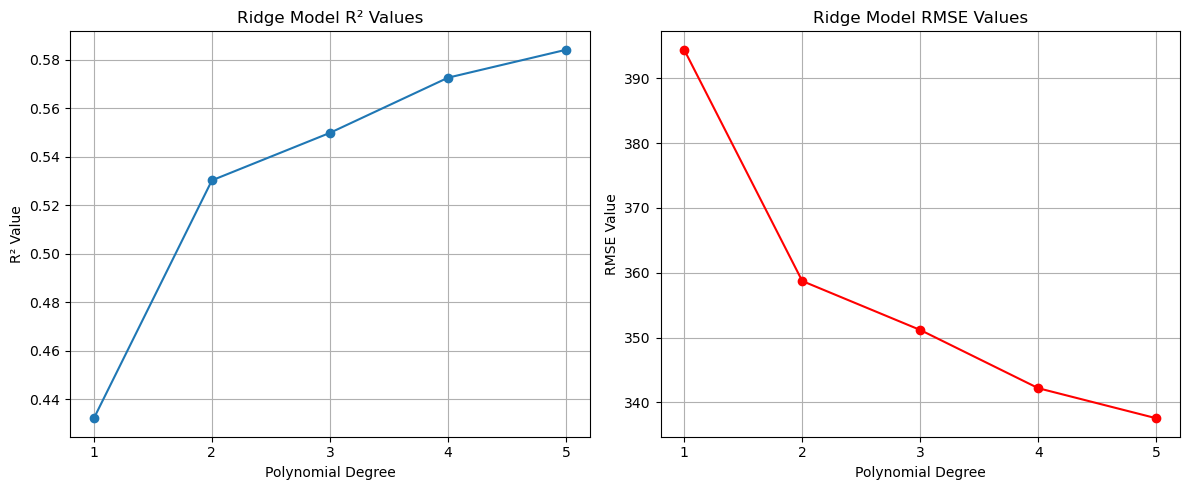

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

# 假设 valid_data 是你的 DataFrame

# 创建哑变量
dummy_variables = pd.get_dummies(valid_data['category'], prefix='category')

# 将哑变量添加到 DataFrame
valid_data_with_dummies = pd.concat([valid_data, dummy_variables], axis=1)

# 准备基础特征
base_features = ['nsb'] + list(dummy_variables.columns)

# 定义正则化模型
models = {
    "Ridge": Ridge(alpha=1.0),  # 适当调整 alpha 值
}

# 存储每个模型的 R² 和 RMSE 值
r2_values = {name: [] for name in models.keys()}
rmse_values = {name: [] for name in models.keys()}

# 标准化
scaler = StandardScaler()

# 逐步增加交互项的阶次
for degree in range(1, 6):
    # 创建多项式特征
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(valid_data_with_dummies[base_features])
    
    # 标准化特征
    X_scaled = scaler.fit_transform(X_poly)
    y = valid_data_with_dummies['gno']

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 训练和评估每个模型
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_values[name].append(r2)
        rmse_values[name].append(rmse)

        # 输出统计数据
        print(f"\n{name} 回归模型包含到 nsb^{degree} 的交互项：")
        print(f"截距（Intercept）：{model.intercept_}")
        print(f"R² 值：{r2:.4f}")
        print(f"RMSE 值：{rmse:.4f}")

# 绘制 R² 和 RMSE 图表
degrees = range(1, 6)
for name in models.keys():
    plt.figure(figsize=(12, 5))

    # R² 图表
    plt.subplot(1, 2, 1)
    plt.plot(degrees, r2_values[name], marker='o', label='R²')
    plt.title(f'{name} Model R² Values')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R² Value')
    plt.xticks(degrees)
    plt.grid(True)

    # RMSE 图表
    plt.subplot(1, 2, 2)
    plt.plot(degrees, rmse_values[name], marker='o', color='r', label='RMSE')
    plt.title(f'{name} Model RMSE Values')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('RMSE Value')
    plt.xticks(degrees)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [19]:
# 检查 stations 列中是否有属于第一个站点的物种点
station_1_exists = valid_data['stations'].apply(lambda x: 1 in x)

# 输出结果
if station_1_exists.any():
    print("valid_data 中包含属于第一个站点的物种点。")
else:
    print("valid_data 中不包含属于第一个站点的物种点。")


valid_data 中不包含属于第一个站点的物种点。


加入station作为第二个哑变量

线性回归模型统计数据：
截距（Intercept）：1727.600143118732
系数（Coefficients）：
  nsb: 0.41570682441872514
  category_1: -0.9323391135551446
  category_2: -9.241816117768861
  category_3: -0.07453364831171284
  category_4: -7.759360449671577
  category_5: 28.387676908931333
  category_6: -7.217702852975268
  category_7: -12.716579930660073
  category_8: 12.902386598571606
  category_9: -3.3477313945616967
  station_2: -910.6274166492365
  station_3: -167.45912179387165
  station_4: 684.1785305876451
  station_5: -76.29385101235025
  station_6: 408.459603053077
  station_7: -920.6133065425906
  station_8: 1088.9013236971052
  station_9: 710.3287296850855
  station_10: -816.8744910248623
R² 值：1.00


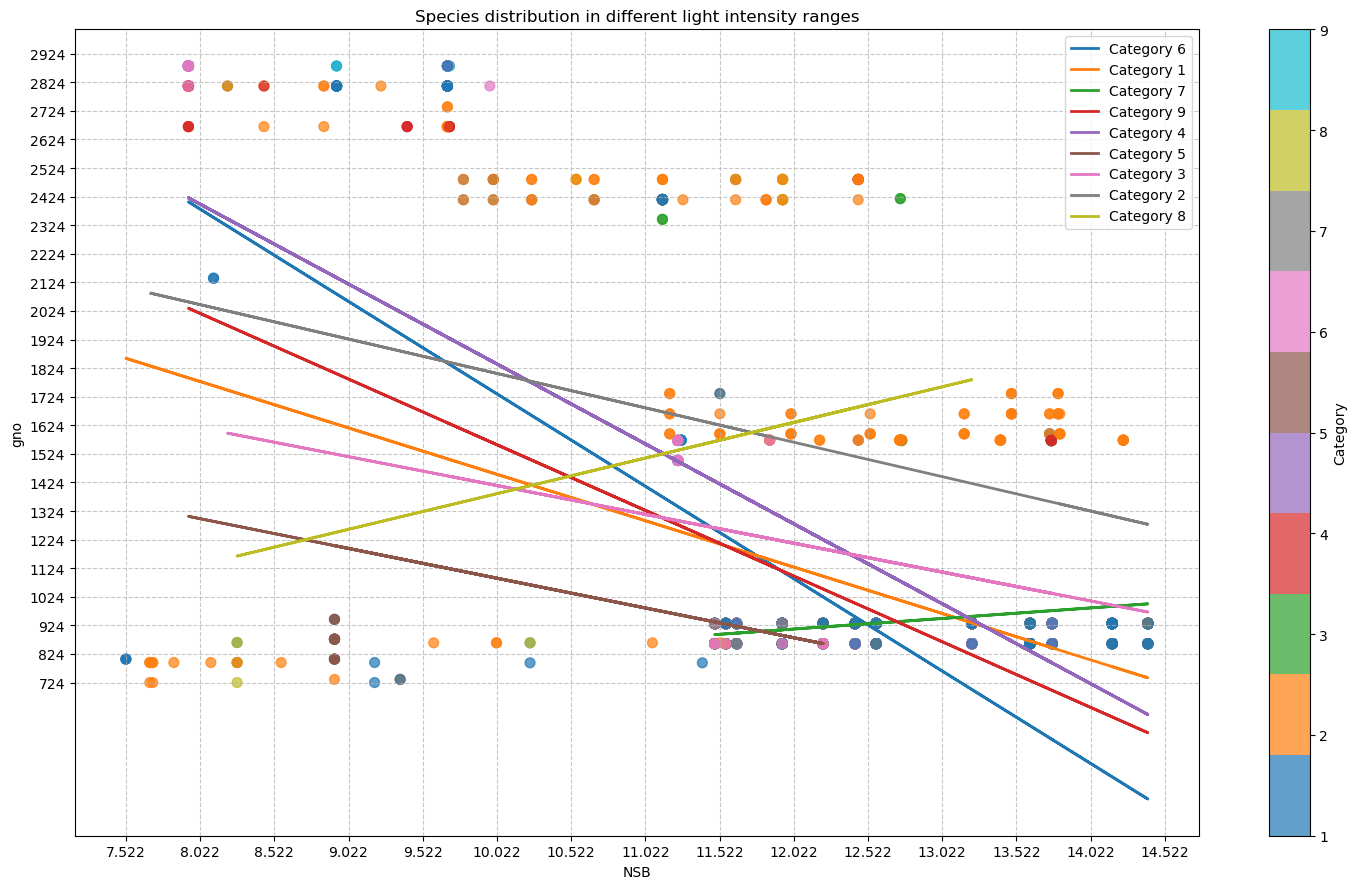

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 假设 valid_data 是你的 DataFrame

# 创建 category 和 stations 的哑变量，不丢弃第一类
category_dummies = pd.get_dummies(valid_data['category'], prefix='category', drop_first=False)
stations_dummies = pd.get_dummies(valid_data['stations'].apply(lambda x: x[0]), prefix='station', drop_first=False)

# 将哑变量添加到 DataFrame
valid_data_with_dummies = pd.concat([valid_data, category_dummies, stations_dummies], axis=1)

plt.figure(figsize=(15, 9))

# 绘制散点图
scatter = plt.scatter(valid_data['nsb'], valid_data['gno'], 
                      c=valid_data['category'], cmap='tab10', alpha=0.7, s=50)

# 准备数据
X = valid_data_with_dummies[['nsb'] + list(category_dummies.columns) + list(stations_dummies.columns)]
y = valid_data_with_dummies['gno']

# 多元线性回归模型
model = LinearRegression()
model.fit(X, y)

# 预测值
y_pred = model.predict(X)

# 模型评估
r2 = r2_score(y, y_pred)

# 输出统计数据
print("线性回归模型统计数据：")
print(f"截距（Intercept）：{model.intercept_}")
print("系数（Coefficients）：")
for feature, coef in zip(['nsb'] + list(category_dummies.columns) + list(stations_dummies.columns), model.coef_):
    print(f"  {feature}: {coef}")
print(f"R² 值：{r2:.2f}")

# 为每个类别绘制单独的回归线
categories = valid_data['category'].unique()
for category in categories:
    subset = valid_data[valid_data['category'] == category]
    X_subset = subset[['nsb']]
    y_subset = subset['gno']
    
    # 简单线性回归
    model_subset = LinearRegression()
    model_subset.fit(X_subset, y_subset)
    y_subset_pred = model_subset.predict(X_subset)
    
    plt.plot(subset['nsb'], y_subset_pred, linewidth=2, label=f'Category {category}')

plt.title('Species distribution in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('gno')
plt.xticks(ticks=np.arange(valid_data['nsb'].min(), valid_data['nsb'].max() + 0.5, 0.5))
plt.yticks(ticks=np.arange(valid_data['gno'].min(), valid_data['gno'].max() + 100, 100))
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Category')
plt.legend()
plt.tight_layout()
plt.show()


发现过拟合，因此引入正则化。另外将数据分为训练集和测试集

Ridge 回归模型统计数据：
训练集 RMSE：35.82
测试集 RMSE：40.84
测试集 R² 值：0.99


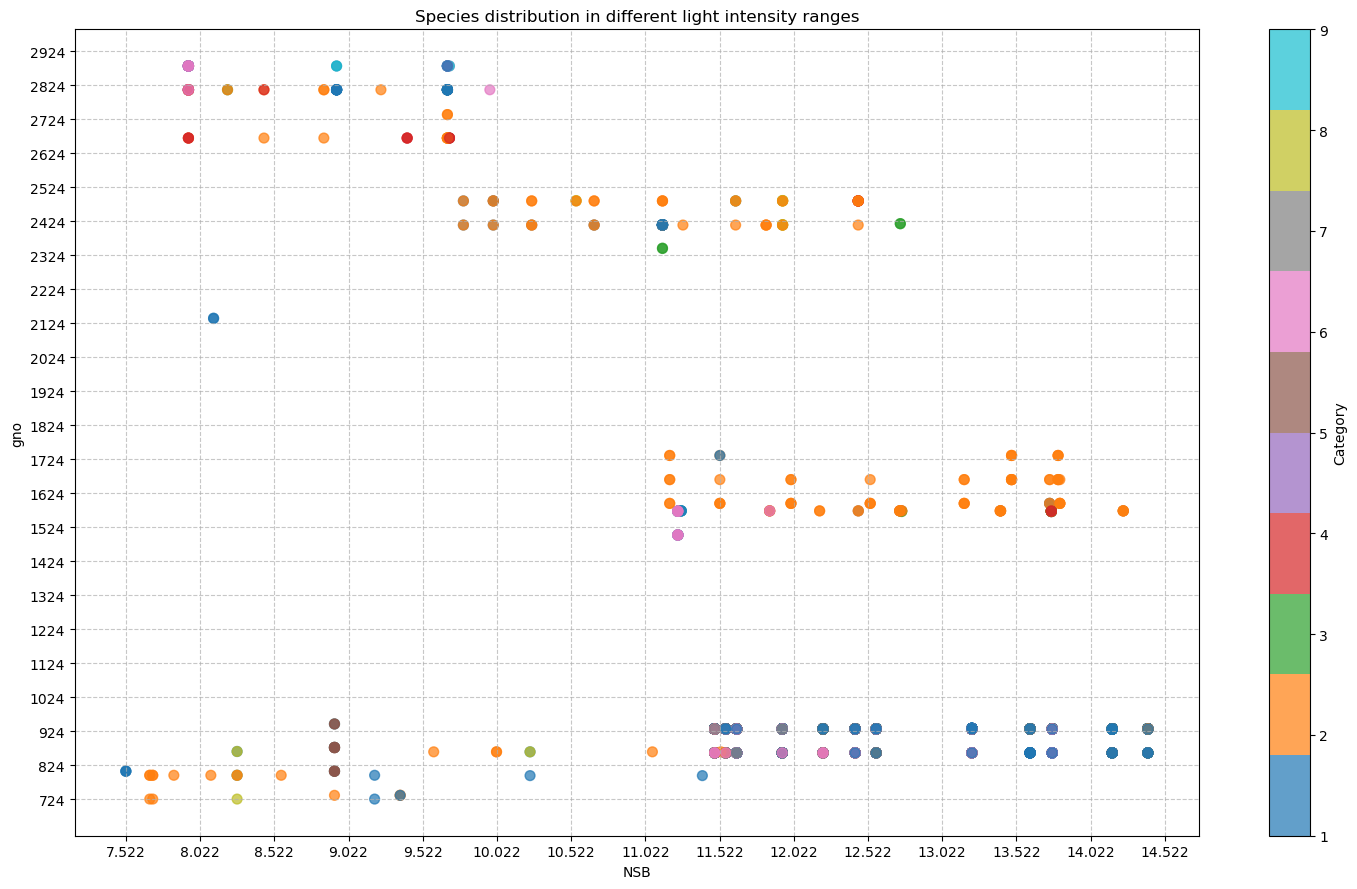

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 假设 valid_data 是你的 DataFrame

# 创建 category 和 stations 的哑变量
category_dummies = pd.get_dummies(valid_data['category'], prefix='category', drop_first=False)
stations_dummies = pd.get_dummies(valid_data['stations'].apply(lambda x: x[0]), prefix='station', drop_first=False)

# 将哑变量添加到 DataFrame
valid_data_with_dummies = pd.concat([valid_data, category_dummies, stations_dummies], axis=1)

# 准备数据
X = valid_data_with_dummies[['nsb'] + list(category_dummies.columns) + list(stations_dummies.columns)]
y = valid_data_with_dummies['gno']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 Ridge 回归模型
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# 预测
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

# 计算 RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 模型评估
r2 = r2_score(y_test, y_test_pred)

# 输出统计数据
print("Ridge 回归模型统计数据：")
print(f"训练集 RMSE：{train_rmse:.2f}")
print(f"测试集 RMSE：{test_rmse:.2f}")
print(f"测试集 R² 值：{r2:.2f}")

# 绘制散点图和回归线
plt.figure(figsize=(15, 9))
scatter = plt.scatter(valid_data['nsb'], valid_data['gno'], 
                      c=valid_data['category'], cmap='tab10', alpha=0.7, s=50)

plt.title('Species distribution in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('gno')
plt.xticks(ticks=np.arange(valid_data['nsb'].min(), valid_data['nsb'].max() + 0.5, 0.5))
plt.yticks(ticks=np.arange(valid_data['gno'].min(), valid_data['gno'].max() + 100, 100))
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Category')
plt.tight_layout()
plt.show()


添加交互项


Ridge 回归模型包含到 nsb^1 的交互项：
截距（Intercept）：1080.171896494585
R² 值：0.3515
RMSE 值：421.4764

Ridge 回归模型包含到 nsb^2 的交互项：
截距（Intercept）：1084.9560629066139
R² 值：0.9949
RMSE 值：37.3675

Ridge 回归模型包含到 nsb^3 的交互项：
截距（Intercept）：1084.865619930318
R² 值：0.9948
RMSE 值：37.7238


/var/folders/_p/fnnym9496hj_jzyg9y4_36nm0000gn/T/ipykernel_31077/285915381.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'nsb*{c}*{s}'] = df['nsb'] * df[c] * df[s]
/var/folders/_p/fnnym9496hj_jzyg9y4_36nm0000gn/T/ipykernel_31077/285915381.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}*{s}'] = df[c] * df[s]
/var/folders/_p/fnnym9496hj_jzyg9y4_36nm0000gn/T/ipykernel_31077/285915381.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 


Ridge 回归模型包含到 nsb^4 的交互项：
截距（Intercept）：1084.826205577202
R² 值：0.9945
RMSE 值：38.8432

Ridge 回归模型包含到 nsb^5 的交互项：
截距（Intercept）：1084.8091066486336
R² 值：0.9941
RMSE 值：40.0357


/var/folders/_p/fnnym9496hj_jzyg9y4_36nm0000gn/T/ipykernel_31077/285915381.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'nsb^5*{c}*{s}'] = df['nsb^5'] * df[c] * df[s]
/var/folders/_p/fnnym9496hj_jzyg9y4_36nm0000gn/T/ipykernel_31077/285915381.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'nsb^5*{c}*{s}'] = df['nsb^5'] * df[c] * df[s]
/var/folders/_p/fnnym9496hj_jzyg9y4_36nm0000gn/T/ipykernel_31077/285915381.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fr

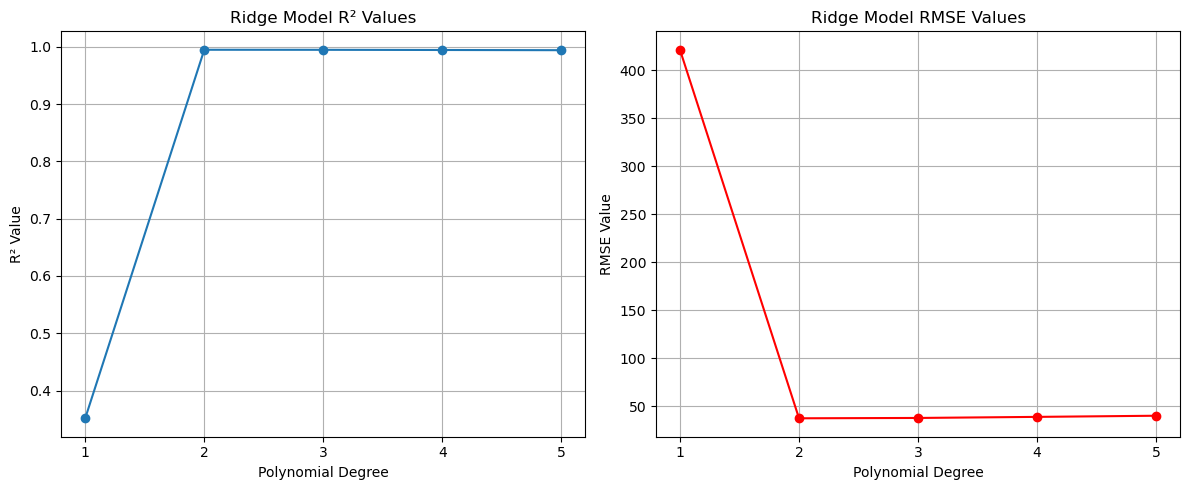

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 假设 valid_data 是你的 DataFrame

# 创建 category 和 stations 的哑变量
category_dummies = pd.get_dummies(valid_data['category'], prefix='category')
stations_dummies = pd.get_dummies(valid_data['stations'].apply(lambda x: x[0]), prefix='station')

# 将哑变量添加到 DataFrame
valid_data_with_dummies = pd.concat([valid_data, category_dummies, stations_dummies], axis=1)

# 定义正则化模型
models = {
    "Ridge": Ridge(alpha=1.0),  # 适当调整 alpha 值
}

# 存储每个模型的 R² 和 RMSE 值
r2_values = {name: [] for name in models.keys()}
rmse_values = {name: [] for name in models.keys()}

# 标准化
scaler = StandardScaler()

# 添加交互项
def add_interaction_terms(df, degree):
    if degree >= 1:
        # Polynomial degree 1 (一次项)
        df['nsb'] = df['nsb']
    if degree >= 2:
        # Polynomial degree 2 (二次项)
        df['nsb^2'] = df['nsb'] ** 2
        for c in category_dummies.columns:
            for s in stations_dummies.columns:
                df[f'{c}*{s}'] = df[c] * df[s]
                df[f'nsb*{c}'] = df['nsb'] * df[c]
                df[f'nsb*{s}'] = df['nsb'] * df[s]
                df[f'nsb^2*{c}'] = df['nsb^2'] * df[c]
                df[f'nsb^2*{s}'] = df['nsb^2'] * df[s]
                df[f'nsb^2*{c}*{s}'] = df['nsb^2'] * df[c] * df[s]
                df[f'nsb*{c}*{s}'] = df['nsb'] * df[c] * df[s]
    if degree >= 3:
        # Polynomial degree 3 (三次项)
        df['nsb^3'] = df['nsb'] ** 3
        for c in category_dummies.columns:
            for s in stations_dummies.columns:
                df[f'nsb^3*{c}'] = df['nsb^3'] * df[c]
                df[f'nsb^3*{s}'] = df['nsb^3'] * df[s]
                df[f'nsb^3*{c}*{s}'] = df['nsb^3'] * df[c] * df[s]
    if degree >= 4:
        # Polynomial degree 4 (四次项)
        df['nsb^4'] = df['nsb'] ** 4
        for c in category_dummies.columns:
            for s in stations_dummies.columns:
                df[f'nsb^4*{c}'] = df['nsb^4'] * df[c]
                df[f'nsb^4*{s}'] = df['nsb^4'] * df[s]
                df[f'nsb^4*{c}*{s}'] = df['nsb^4'] * df[c] * df[s]
    if degree >= 5:
        # Polynomial degree 5 (五次项)
        df['nsb^5'] = df['nsb'] ** 5
        for c in category_dummies.columns:
            for s in stations_dummies.columns:
                df[f'nsb^5*{c}'] = df['nsb^5'] * df[c]
                df[f'nsb^5*{s}'] = df['nsb^5'] * df[s]
                df[f'nsb^5*{c}*{s}'] = df['nsb^5'] * df[c] * df[s]
    return df

# 逐步增加交互项的阶次
for degree in range(1, 6):
    # 添加交互项到数据集中
    valid_data_with_interactions = add_interaction_terms(valid_data_with_dummies.copy(), degree)

    # 更新特征列表，确保只包含数值列
    interaction_features = valid_data_with_interactions.select_dtypes(include=[np.number]).columns.tolist()
    interaction_features.remove('gno')

    # 选择特定交互项
    X = valid_data_with_interactions[interaction_features]
    
    # 标准化特征
    X_scaled = scaler.fit_transform(X)
    y = valid_data_with_interactions['gno']

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 训练和评估每个模型
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_values[name].append(r2)
        rmse_values[name].append(rmse)

        # 输出统计数据
        print(f"\n{name} 回归模型包含到 nsb^{degree} 的交互项：")
        print(f"截距（Intercept）：{model.intercept_}")
        print(f"R² 值：{r2:.4f}")
        print(f"RMSE 值：{rmse:.4f}")

# 绘制 R² 和 RMSE 图表
degrees = range(1, 6)
for name in models.keys():
    plt.figure(figsize=(12, 5))

    # R² 图表
    plt.subplot(1, 2, 1)
    plt.plot(degrees, r2_values[name], marker='o', label='R²')
    plt.title(f'{name} Model R² Values')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R² Value')
    plt.xticks(degrees)
    plt.grid(True)

    # RMSE 图表
    plt.subplot(1, 2, 2)
    plt.plot(degrees, rmse_values[name], marker='o', color='r', label='RMSE')
    plt.title(f'{name} Model RMSE Values')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('RMSE Value')
    plt.xticks(degrees)
    plt.grid(True)

    plt.tight_layout()
    plt.show()
